Implementation of AGE \
D. Ulyanov et al. Adversarial generator-encoder networks, AAAI 2018\
https://www.aaai.org/ocs/index.php/AAAI/AAAI18/paper/viewPaper/16568

In [1]:
import time
import torch
import random
from torch import cuda, device, nn, utils, optim
from torch.autograd import Variable
from torchsummary import summary
import torchvision as tv
from matplotlib import pyplot as plt

print(cuda.is_available())
device = device('cuda:0')
print(device)

#manualSeed = 999
#manualSeed = random.randint(1, 10000)
#print("Random Seed: ", manualSeed)
#random.seed(manualSeed)
#torch.manual_seed(manualSeed)

image_size = 32
nz = 256
nf = 64
nc = 3; 

True
cuda:0


In [2]:
class Encoder(nn.Module):
    def __init__(self, nc, nf, nz):
        super(Encoder, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(nc, nf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(nf, nf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(nf*2, nf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf*4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # for 16x16
            #nn.AvgPool2d(2),
            
            # for 32x32
            nn.Conv2d(nf*4, nz, 4, 2, 1, bias=True),
            nn.AvgPool2d(2),
            
            # for 64x64
            #nn.Conv2d(nf*4, nf*8, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(nf*8),
            #nn.LeakyReLU(0.2, inplace=True),
            #nn.Conv2d(nf*8, nz, 4, 1, 0, bias=True),
        )
        
    def forward(self, input):
        return self.net(input)
    
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

In [3]:
class Decoder(nn.Module):
    def __init__(self, nc, nf, nz):
        super(Decoder, self).__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(nz, nf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(nf*8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(nf*8, nf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf*4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(nf*4, nf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf * 2),
            nn.ReLU(True),
            
            # for 16x16
            #nn.Conv2d(nf*2, nc, 1, bias=True),
            
            # for 32x32 and 64x64
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(nf*2, nf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nf),
            nn.ReLU(True),
            
            # for 32x32
            nn.Conv2d(nf, nc, 1, bias=True),
            # for 64x64
            #nn.ConvTranspose2d(nf, nc, 4, 2, 1, bias=False),
            
            nn.Tanh(),
        )
    
    def forward(self, input):
        return self.net(input)
    
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

In [4]:
enc = Encoder(nc=nc, nf=nf, nz=nz).to(device)
summary(enc, (nc, image_size, image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           3,072
         LeakyReLU-2           [-1, 64, 16, 16]               0
            Conv2d-3            [-1, 128, 8, 8]         131,072
       BatchNorm2d-4            [-1, 128, 8, 8]             256
         LeakyReLU-5            [-1, 128, 8, 8]               0
            Conv2d-6            [-1, 256, 4, 4]         524,288
       BatchNorm2d-7            [-1, 256, 4, 4]             512
         LeakyReLU-8            [-1, 256, 4, 4]               0
            Conv2d-9            [-1, 256, 2, 2]       1,048,832
        AvgPool2d-10            [-1, 256, 1, 1]               0
Total params: 1,708,032
Trainable params: 1,708,032
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.54
Params size (MB): 6.52
Estimat

In [5]:
dec = Decoder(nc=nc, nf=nf, nz=nz).to(device)
summary(dec, (nz, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       2,097,152
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
           Conv2d-13            [-1, 3, 32, 32]             195
             Tanh-14            [-1, 3,

In [6]:
"""
batch_size = 64

dataroot = '/raid/artem/tmp/cifar'
transform = tv.transforms.Compose([tv.transforms.Resize(image_size),
                                tv.transforms.CenterCrop(image_size),
                                tv.transforms.ToTensor(),
                                tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#dataset = tv.datasets.ImageFolder(root=dataroot, transform = transform)
dataset = tv.datasets.MNIST(root=dataroot, download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=8, drop_last=True)
print(len(dataloader))
"""

"\nbatch_size = 64\n\ndataroot = '/raid/artem/tmp/cifar'\ntransform = tv.transforms.Compose([tv.transforms.Resize(image_size),\n                                tv.transforms.CenterCrop(image_size),\n                                tv.transforms.ToTensor(),\n                                tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])\n#dataset = tv.datasets.ImageFolder(root=dataroot, transform = transform)\ndataset = tv.datasets.MNIST(root=dataroot, download=True)\ndataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,\n                                         shuffle=True, num_workers=8, drop_last=True)\nprint(len(dataloader))\n"

In [7]:
#"""
batch_size = 64
#dataroot = '/raid/artem/data/cityscapes/dataset_16x/leftImg8bitAll'
dataroot = '/raid/artem/tmp/gta_256x128/train/'
transform = tv.transforms.Compose([tv.transforms.Resize(image_size),
                                tv.transforms.CenterCrop(image_size),
                                tv.transforms.ToTensor(),
                                tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = tv.datasets.ImageFolder(root=dataroot, transform = transform)
dataloader = utils.data.DataLoader(dataset=dataset,
                                   batch_size=batch_size,
                                   shuffle=True,
                                   num_workers=8,
                                   drop_last=True)
print(len(dataloader))
#"""

390


In [8]:
def kl_divergence(z1, z2=None):
    return kl_divergence_param(z1, z2)
    #return kl_divergence_nonparam(z1, z2)

def kl_divergence_param(z1, z2=None):
    mu = z1.mean(dim=1)
    var = z1.var(dim=1)
    
    return torch.mean(0.5 * (mu.pow(2) + var.pow(2) - 1) - var.log())

klloss = torch.nn.KLDivLoss()

def kl_divergence_nonparam(z1, z2=None):
    z2 = sample_z()
    kl = klloss(z1, z2.to(device))
    
    return kl

def cos_similarity(z1, z2):
    cos = nn.CosineSimilarity(dim=1)
    return 2 - cos(z1, z2).mean()

def sample_z():
    return sample_sphere()
    #return sample_normal()

def sample_sphere():
    zz = torch.FloatTensor(batch_size, nz, 1, 1)
    zz.data.normal_(0, 1)
    zz.data.div_(zz.data.norm(2, dim=1).unsqueeze_(-1).expand_as(zz))
    return zz

import torch.distributions.multivariate_normal as mn
mvn = mn.MultivariateNormal(torch.zeros(nz), torch.eye(nz))

def sample_normal():
    lst = [torch.Tensor(mvn.sample()) for i in range(0, batch_size)]
    zz = torch.stack(lst).unsqueeze_(-1).unsqueeze_(-1)
    return zz
    

criterion_l1 = torch.nn.L1Loss()

In [9]:
enc = Encoder(nc=nc, nf=nf, nz=nz).to(device)
dec = Decoder(nc=nc, nf=nf, nz=nz).to(device)

In [10]:
lr = 2e-4
optimizer_dec = optim.Adam(dec.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_enc = optim.Adam(enc.parameters(), lr=lr, betas=(0.5, 0.999))

In [11]:
enc_losses = []
dec_losses = []

enc.apply(enc.weights_init)
dec.apply(dec.weights_init)

epochs = 10
lr_scheduler_enc = optim.lr_scheduler.MultiStepLR(optimizer_enc, [100], gamma=0.1)
lr_scheduler_dec = optim.lr_scheduler.MultiStepLR(optimizer_dec, [100], gamma=0.1)

print_iter = len(dataloader) / 2#20
for epoch in range(1, epochs + 1):
    epoch_start = time.time()
    
    for idx, (data, _) in enumerate(dataloader):
        
        start = time.time()
        #if idx == 1: break
        
        batch_size = data.shape[0]
        
        x = Variable(data).to(device)
        ex = enc(x)
        enc_ex_loss = kl_divergence(ex, sample_z().to(device))
                
        gex = dec(ex)
        enc_gex_loss = criterion_l1(gex, x)
        
        z = Variable(sample_z()).to(device)
        gz = dec(z)
        egz = enc(gz)
        
        enc_egz_loss = -kl_divergence(egz, z)
        
        #enc_cos_loss = cos_similarity(egz, z)
                
        enc_loss = enc_ex_loss + 100*enc_gex_loss + enc_egz_loss #+ enc_cos_loss
        enc.zero_grad()
        #enc_loss.backward(retain_graph=True)
        enc_loss.backward()
        optimizer_enc.step()
        enc_losses.append(enc_loss.item())
        
        # Dec
        for i in range(0,3):
            z = Variable(sample_z()).to(device)
            gz = dec(z)
            egz = enc(gz)

            dec_egz_loss = kl_divergence(egz, z)

            dec_cos_loss = cos_similarity(egz, z)
            
            #ex = enc(x)
            #gex = dec(ex)
            #dec_gex_loss = criterion_l1(gex, x)

            dec_loss = dec_egz_loss + 10*dec_cos_loss #+ dec_gex_loss
            dec.zero_grad()
            #dec_loss.backward(retain_graph=True)
            dec_loss.backward()
            optimizer_dec.step()
            dec_losses.append(dec_loss.item())

        if (not (idx % print_iter)) or (not (idx % len(dataloader))):
            print('[%d/%d;%d/%d]: loss_dec: %.3f, loss_enc: %.3f'
              % (idx, len(dataloader),
                 (epoch), epochs, 
                 torch.mean(torch.FloatTensor(dec_losses)), 
                 torch.mean(torch.FloatTensor(enc_losses))))
    print('Time: ', time.time() - epoch_start)
    for param_group in optimizer_enc.param_groups:
        print('lr:', param_group['lr'])
    lr_scheduler_enc.step()
    lr_scheduler_dec.step()

[0/390;1/10]: loss_dec: 21.312, loss_enc: 41.874
[195/390;1/10]: loss_dec: 18.225, loss_enc: 34.294
Time:  39.50624680519104
lr: 0.0002
[0/390;2/10]: loss_dec: 18.522, loss_enc: 26.107
[195/390;2/10]: loss_dec: 18.166, loss_enc: 21.536
Time:  40.65741944313049
lr: 0.0002
[0/390;3/10]: loss_dec: 17.919, loss_enc: 19.425
[195/390;3/10]: loss_dec: 17.712, loss_enc: 18.112
Time:  39.42626094818115
lr: 0.0002
[0/390;4/10]: loss_dec: 17.509, loss_enc: 17.001
[195/390;4/10]: loss_dec: 17.401, loss_enc: 16.413
Time:  40.69515800476074
lr: 0.0002
[0/390;5/10]: loss_dec: 17.274, loss_enc: 15.781
[195/390;5/10]: loss_dec: 17.260, loss_enc: 15.819
Time:  40.3825523853302
lr: 0.0002
[0/390;6/10]: loss_dec: 17.285, loss_enc: 16.024
[195/390;6/10]: loss_dec: 17.303, loss_enc: 15.998
Time:  41.126577615737915
lr: 0.0002
[0/390;7/10]: loss_dec: 17.321, loss_enc: 15.860
[195/390;7/10]: loss_dec: 17.316, loss_enc: 15.630
Time:  41.233288526535034
lr: 0.0002
[0/390;8/10]: loss_dec: 17.349, loss_enc: 15.71

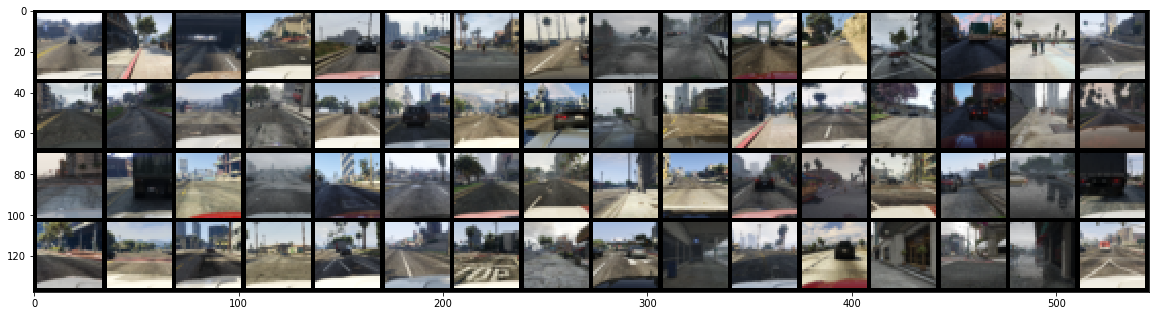

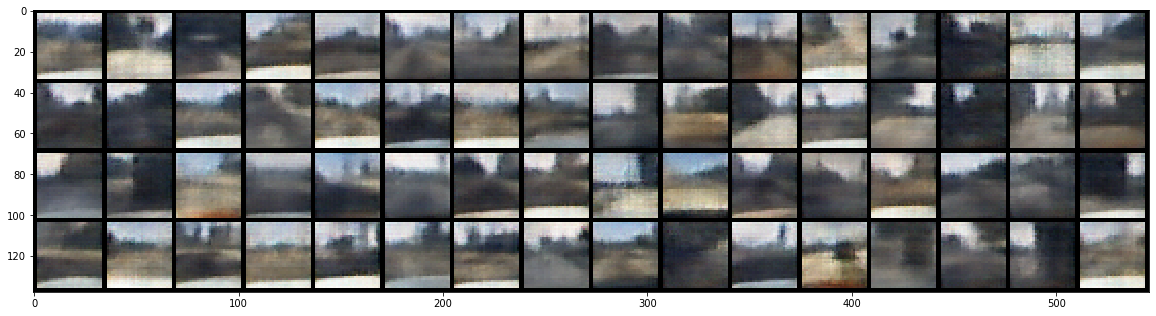

In [12]:
idx, (data, label) = next(enumerate(dataloader))
x = Variable(data)

plt.figure(figsize=(20,20))
plt.imshow(tv.utils.make_grid(data[:64], nrow=16, normalize=True).permute(1, 2, 0))
plt.show()

z = enc(x.to(device))
rec = dec(z)
y = rec.detach().cpu()

plt.figure(figsize=(20,20))
plt.imshow(tv.utils.make_grid(y[:64],  nrow=16, normalize=True).permute(1, 2, 0))
plt.show()

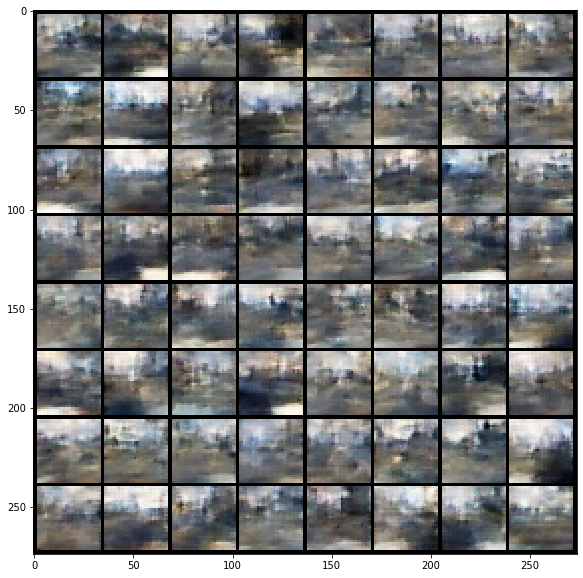

In [13]:
z1 = Variable(sample_z()).to(device)
#z1 = Variable(dtype(opt.batch_size, opt.nz, 1, 1).normal_(0, 1), volatile=True)
#z1 = normalize(z)
y1 = dec(z1).detach().cpu()
plt.figure(figsize=(10,10))
plt.imshow(tv.utils.make_grid(y1[:64],  nrow=8, normalize=True).permute(1, 2, 0)); plt.show()

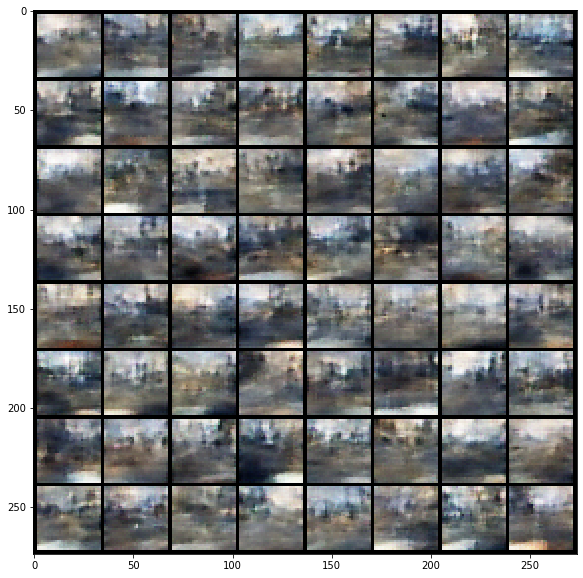

In [14]:
loc = torch.zeros(nz*batch_size)
scale = torch.ones(nz*batch_size)
mvn = torch.distributions.MultivariateNormal(loc, scale_tril=torch.diag(scale))
z2 = Variable(mvn.sample().view(batch_size, nz, 1, 1).to(device))
z2 = z2.div(z2.norm(2, dim=0).expand_as(z2))
y2 = dec(z2).detach().cpu()

plt.figure(figsize=(10,10))
plt.imshow(tv.utils.make_grid(y2[:64],  nrow=8, normalize=True).permute(1, 2, 0)); plt.show()